In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

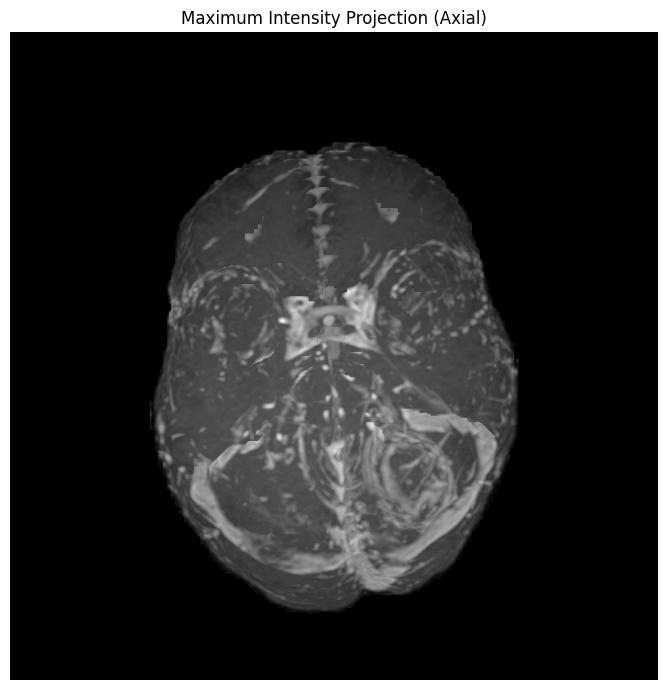

In [2]:
# --------------------------
# 1. Load MRI volume
# --------------------------
nii_path = "/home/johannes/Data/SSD_2.0TB/GNN_pCR/data/brain_cancer/Lumiere/raw/Patient-001/week-000-1/HD-GLIO-AUTO-segmentation/registered/CT1_r2s_bet_reg.nii" 
img = nib.load(nii_path)
volume = img.get_fdata()  # 3D numpy array

# --------------------------
# 2. Maximum Intensity Projection (axial axis)
# --------------------------
# Axial axis in MRI is usually the "z" dimension → axis=-1 or axis=2
mip_axial = np.max(volume, axis=2)

# Optionally normalize for display
mip_norm = (mip_axial - mip_axial.min()) / (mip_axial.max() - mip_axial.min())

# --------------------------
# 3. Visualize the MIP
# --------------------------
plt.figure(figsize=(7, 7))
plt.imshow(mip_norm.T, cmap="gray", origin="lower")
plt.title("Maximum Intensity Projection (Axial)")
plt.axis("off")
plt.tight_layout()
plt.show()


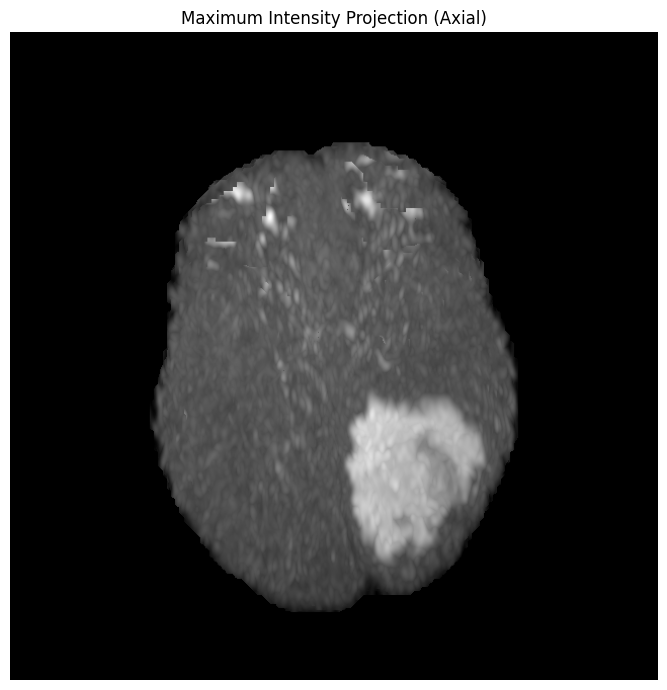

In [15]:
# --------------------------
# 1. Load MRI volume
# --------------------------
nii_path = "/home/johannes/Data/SSD_2.0TB/GNN_pCR/data/brain_cancer/Lumiere/raw/Patient-001/week-000-1/HD-GLIO-AUTO-segmentation/registered/FLAIR_r2s_bet_reg.nii.gz" 
img = nib.load(nii_path)
volume = img.get_fdata()  # 3D numpy array

# --------------------------
# 2. Maximum Intensity Projection (axial axis)
# --------------------------
# Axial axis in MRI is usually the "z" dimension → axis=-1 or axis=2
mip_axial = np.max(volume, axis=2)

# Optionally normalize for display
mip_norm = (mip_axial - mip_axial.min()) / (mip_axial.max() - mip_axial.min())

# --------------------------
# 3. Visualize the MIP
# --------------------------
plt.figure(figsize=(7, 7))
plt.imshow(mip_norm.T, cmap="gray", origin="lower")
plt.title("Maximum Intensity Projection (Axial)")
plt.axis("off")
plt.tight_layout()
plt.show()

/tmp/ipykernel_711568/2961043149.py:139: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_np = imageio.imread(sample_path)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


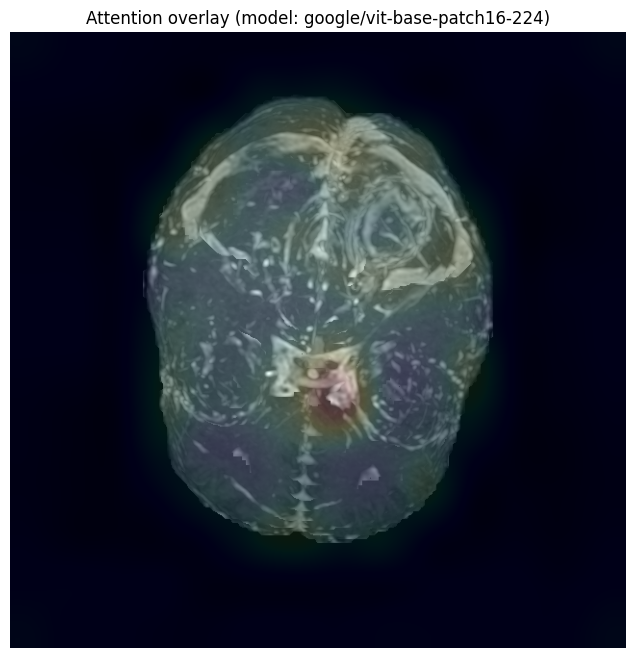

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from transformers import ViTModel, ViTFeatureExtractor  # works for ViT-like models

# -------------------------
# Helper: attention rollout
# -------------------------
def attention_rollout(attentions, discard_ratio=0.0, head_fusion="mean"):
    """
    Computes attention rollout as in https://arxiv.org/abs/2005.00928
    attentions: list of tensors, one per layer: (batch, n_heads, N, N)
    returns: rollout (batch, N, N)
    head_fusion: "mean" or "max"
    """
    # convert list -> tensor (L, B, H, N, N)
    attn = torch.stack(attentions)  # [L, B, H, N, N]
    L, B, H, N, _ = attn.shape

    # optionally drop lowest-value heads (not necessary here)
    if head_fusion == "mean":
        attn_heads_fused = attn.mean(dim=2)  # [L, B, N, N]
    elif head_fusion == "max":
        attn_heads_fused = attn.max(dim=2).values
    else:
        raise ValueError("head_fusion must be 'mean' or 'max'")

    # discard small attentions if requested
    if discard_ratio > 0:
        flat = attn_heads_fused.reshape(L, B, -1)
        _, idx = flat.topk(int(flat.shape[-1] * (1 - discard_ratio)), dim=-1)
        mask = torch.zeros_like(flat)
        # keep top indices per [L,B]
        for l in range(L):
            for b in range(B):
                mask[l, b, idx[l, b]] = 1
        attn_heads_fused = (flat * mask).reshape_as(attn_heads_fused)

    # add identity to include residual connection
    eye = torch.eye(N, device=attn_heads_fused.device).unsqueeze(0).unsqueeze(0)  # [1,1,N,N]
    attn_aug = attn_heads_fused + eye  # broadcasting [L,B,N,N]
    # normalize rows
    attn_aug = attn_aug / attn_aug.sum(dim=-1, keepdim=True)

    # rollout: multiply attentions across layers
    rollout = attn_aug[0]  # [B, N, N]
    for i in range(1, L):
        rollout = torch.matmul(attn_aug[i], rollout)
    # rollout now [B, N, N]
    return rollout

# -------------------------
# Main function
# -------------------------
def get_dino_attention_overlay(
    img_np,                 # numpy array HxW or HxWx3, dtype uint8 or float
    model_name="google/vit-base-patch16-224",  # replace with DINOv3-compatible checkpoint if available
    device="cuda" if torch.cuda.is_available() else "cpu",
    show=True
):
    """
    Returns overlayed figure and the raw attention map (upsampled to image size).
    If your DINOv3 model is available via HuggingFace and returns attentions, set model_name accordingly.
    """
    # --- Prepare image ---
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    if img_np.dtype != np.uint8:
        # assume floats in [0,1] -> convert to uint8
        img_disp = np.clip((img_np * 255.0), 0, 255).astype(np.uint8)
    else:
        img_disp = img_np.copy()

    pil = Image.fromarray(img_disp)

    # Use feature extractor for consistent preprocessing
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    model = ViTModel.from_pretrained(model_name, output_attentions=True).to(device).eval()

    # transform via feature extractor (resizes + center crop for ViT models)
    inputs = feature_extractor(images=pil, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)  # [1, 3, H, W]

    # forward pass: get attentions
    with torch.no_grad():
        outputs = model(pixel_values)
        # outputs.attentions: list(length=L) of tensors (batch, num_heads, seq_len, seq_len)
        attentions = outputs.attentions
        # sanity check
        if attentions is None:
            raise RuntimeError("Model did not return attentions. Make sure the model supports output_attentions=True.")

    # compute rollout
    rollout = attention_rollout(attentions, head_fusion="mean")  # [batch, N, N]
    rollout = rollout[0]  # [N, N]

    # The ViT token layout: class token at index 0, then patch tokens 1..N-1
    # We want class token attention to each patch: grab rollout[class_index, 1:]
    class_attn = rollout[0, 1:]  # [num_patches]
    num_patches = class_attn.shape[0]
    # model config tells patch grid size
    grid_size = int(np.sqrt(num_patches))
    if grid_size * grid_size != num_patches:
        raise RuntimeError(f"Unexpected patch grid: {num_patches} patches is not a square")

    # reshape to grid
    attn_map = class_attn.reshape(grid_size, grid_size).cpu().numpy()

    # resize attention map to image size
    H, W = img_disp.shape[:2]
    attn_map_resized = cv2.resize(attn_map, (W, H), interpolation=cv2.INTER_CUBIC)
    attn_map_resized = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min() + 1e-8)

    if show:
        # overlay
        plt.figure(figsize=(8, 8))
        plt.imshow(img_disp)
        plt.imshow(attn_map_resized, cmap="jet", alpha=0.1)  # colormap + alpha
        plt.axis("off")
        plt.title(f"Attention overlay (model: {model_name})")
        plt.show()

    return attn_map_resized, img_disp

# -------------------------
# Example usage
# -------------------------
if __name__ == "__main__":
    # Suppose img_np is your 2D numpy array (H, W) or (H, W, 3)
    # Example: load a random image for demonstration
    import imageio
    # replace with your numpy image variable
    sample_path = "example.jpg"  # put a path here or create from your numpy array
    try:
        img_np = imageio.imread(sample_path)
    except Exception:
        # fallback: make a synthetic image
        img_np = (np.linspace(0, 255, 224*224).reshape(224,224).astype(np.uint8))

    img_np = mip_norm.T

    # attn_map, img = get_dino_attention_overlay(img_np, model_name="facebook/dinov3-vits16-pretrain-lvd1689m")
    attn_map, img = get_dino_attention_overlay(img_np, model_name="google/vit-base-patch16-224")
